# Salary Predictions Based on Job Descriptions

### The goal of this project is to examine a set of job postings with salaries and then predict salaries for a new set of job postings.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


__author__ = "Matthew Siapno"
__email__ = "matthewsiapno@gmail.com"

### Define the Data Class

In [3]:
def load_file(file):
    '''loads csv to pd dataframe'''
    return pd.read_csv(file)

def consolidate_data(df1, df2, key=None, left_index=False, right_index=False):
    '''perform inner join to return only records that are present in both dataframes'''
    return pd.merge(left=df1, right=df2, how='inner', on=key, left_index=left_index, right_index=right_index)

def clean_data(raw_df):
    '''remove rows that contain salary <= 0 or duplicate job IDs'''
    clean_df = raw_df.drop_duplicates(subset='jobId')
    clean_df = clean_df[clean_df.salary>0]
    return clean_df

def one_hot_encode_feature_df(df, cat_vars=None, num_vars=None):
    '''performs one-hot encoding on all categorical variables and combines result with continous variables'''
    cat_df = pd.get_dummies(df[cat_vars])
    num_df = df[num_vars].apply(pd.to_numeric)
    return pd.concat([cat_df, num_df], axis=1)#,ignore_index=False)

def get_target_df(df, target):
    '''returns target dataframe'''
    return df[target]

def train_model(model, feature_df, target_df, num_procs, mean_mse, cv_std):
    neg_mse = cross_val_score(model, feature_df, target_df, cv=2, n_jobs=num_procs, scoring='neg_mean_squared_error')
    mean_mse[model] = -1.0*np.mean(neg_mse)
    cv_std[model] = np.std(neg_mse)

def print_summary(model, mean_mse, cv_std):
    print('\nModel:\n', model)
    print('Average MSE:\n', mean_mse[model])
    print('Standard deviation during CV:\n', cv_std[model])

def save_results(model, mean_mse, predictions, feature_importances):
    '''saves model, model summary, feature importances, and predictions'''
    with open('model.txt', 'w') as file:
        file.write(str(model))
    feature_importances.to_csv('feature_importances.csv') 
    np.savetxt('predictions.csv', predictions, delimiter=',')

###   Load the Data 

In [2]:
train_feature_df = pd.read_csv('train_features.csv')
test_feature_df = pd.read_csv('test_features.csv')
train_target_df= pd.read_csv('train_salaries.csv')

In [60]:
train_feature_df.head(10)

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16
5,JOB1362684407692,COMP15,MANAGER,DOCTORAL,COMPSCI,FINANCE,2,31
6,JOB1362684407693,COMP15,CFO,NONE,NONE,HEALTH,23,24
7,JOB1362684407694,COMP24,JUNIOR,BACHELORS,CHEMISTRY,EDUCATION,9,70
8,JOB1362684407695,COMP20,JANITOR,HIGH_SCHOOL,NONE,EDUCATION,1,54
9,JOB1362684407696,COMP41,VICE_PRESIDENT,BACHELORS,CHEMISTRY,AUTO,17,68


In [39]:
test_feature_df.head(10)

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362685407687,COMP33,MANAGER,HIGH_SCHOOL,NONE,HEALTH,22,73
1,JOB1362685407688,COMP13,JUNIOR,NONE,NONE,AUTO,20,47
2,JOB1362685407689,COMP10,CTO,MASTERS,BIOLOGY,HEALTH,17,9
3,JOB1362685407690,COMP21,MANAGER,HIGH_SCHOOL,NONE,OIL,14,96
4,JOB1362685407691,COMP36,JUNIOR,DOCTORAL,BIOLOGY,OIL,10,44
5,JOB1362685407692,COMP40,CTO,MASTERS,COMPSCI,FINANCE,6,23
6,JOB1362685407693,COMP32,SENIOR,MASTERS,COMPSCI,SERVICE,6,32
7,JOB1362685407694,COMP11,CEO,BACHELORS,BIOLOGY,SERVICE,9,73
8,JOB1362685407695,COMP39,MANAGER,DOCTORAL,PHYSICS,HEALTH,6,78
9,JOB1362685407696,COMP22,VICE_PRESIDENT,NONE,NONE,AUTO,23,97


In [40]:
train_target_df.head(10)

,jobId,salary
0,JOB1362684407687,130
1,JOB1362684407688,101
2,JOB1362684407689,137
3,JOB1362684407690,142
4,JOB1362684407691,163
5,JOB1362684407692,113
6,JOB1362684407693,178
7,JOB1362684407694,73
8,JOB1362684407695,31
9,JOB1362684407696,104


In [42]:
train_feature_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
jobId                  1000000 non-null object
companyId              1000000 non-null object
jobType                1000000 non-null object
degree                 1000000 non-null object
major                  1000000 non-null object
industry               1000000 non-null object
yearsExperience        1000000 non-null int64
milesFromMetropolis    1000000 non-null int64
dtypes: int64(2), object(6)
memory usage: 61.0+ MB


In [43]:
train_target_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
jobId     1000000 non-null object
salary    1000000 non-null int64
dtypes: int64(1), object(1)
memory usage: 15.3+ MB


In [44]:
test_feature_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
jobId                  1000000 non-null object
companyId              1000000 non-null object
jobType                1000000 non-null object
degree                 1000000 non-null object
major                  1000000 non-null object
industry               1000000 non-null object
yearsExperience        1000000 non-null int64
milesFromMetropolis    1000000 non-null int64
dtypes: int64(2), object(6)
memory usage: 61.0+ MB


### Identify Numerical and Categorical Variables 

In [5]:
train_feature_df.columns

Index(['jobId', 'companyId', 'jobType', 'degree', 'major', 'industry',
       'yearsExperience', 'milesFromMetropolis'],
      dtype='object')

In [3]:
numeric_cols = [  'yearsExperience', 'milesFromMetropolis']

In [4]:
categorical_cols = ['jobId', 'companyId', 'jobType', 'degree', 'major', 'industry']

### Summarize Numerical and Categorical Variables Separatley

In [8]:
train_feature_df.describe(include=np.number)

,yearsExperience,milesFromMetropolis
count,1000000.000000,1000000.000000
mean,11.992386,49.529260
std,7.212391,28.877733
min,0.000000,0.000000
25%,6.000000,25.000000
50%,12.000000,50.000000
75%,18.000000,75.000000
max,24.000000,99.000000


In [6]:
train_feature_df.describe(include = 'O')

,jobId,companyId,jobType,degree,major,industry
count,1000000,1000000,1000000,1000000,1000000,1000000
unique,1000000,63,8,5,9,7
top,JOB1362684522096,COMP39,SENIOR,HIGH_SCHOOL,NONE,WEB
freq,1,16193,125886,236976,532355,143206


### Merge Features and Targes into a Single Dataframe

In [5]:
train_df = pd.merge(train_feature_df,train_target_df, on = 'jobId')

In [91]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
jobId                  1000000 non-null object
companyId              1000000 non-null object
jobType                1000000 non-null object
degree                 1000000 non-null object
major                  1000000 non-null object
industry               1000000 non-null object
yearsExperience        1000000 non-null int64
milesFromMetropolis    1000000 non-null int64
salary                 1000000 non-null int64
dtypes: int64(3), object(6)
memory usage: 76.3+ MB


In [10]:
train_df.head(10)

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163
5,JOB1362684407692,COMP15,MANAGER,DOCTORAL,COMPSCI,FINANCE,2,31,113
6,JOB1362684407693,COMP15,CFO,NONE,NONE,HEALTH,23,24,178
7,JOB1362684407694,COMP24,JUNIOR,BACHELORS,CHEMISTRY,EDUCATION,9,70,73
8,JOB1362684407695,COMP20,JANITOR,HIGH_SCHOOL,NONE,EDUCATION,1,54,31
9,JOB1362684407696,COMP41,VICE_PRESIDENT,BACHELORS,CHEMISTRY,AUTO,17,68,104


## Visualize Target Variable (Salary) 

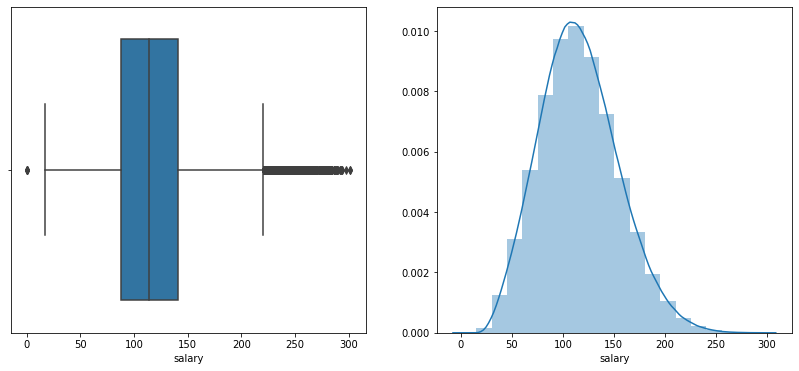

In [6]:
plt.figure(figsize = (14,6))
plt.subplot(1,2,1)  # creates first box plot range
sns.boxplot(train_df.salary)  
plt.subplot(1,2,2)
sns.distplot(train_df.salary, bins = 20)
plt.show()

## Use IQR rule to identify potential outliers 

In [7]:
stat = train_df.salary.describe()
print(stat)
IQR = stat['75%']- stat['25%']
upper = stat['75%'] + 1.5 * IQR 
lower = stat['25%'] - 1.5 * IQR 
print (' The upper and lower bounds for suspected outliers are {} and {}.'.format(upper,lower))

count    1000000.000000
mean         116.061818
std           38.717936
min            0.000000
25%           88.000000
50%          114.000000
75%          141.000000
max          301.000000
Name: salary, dtype: float64
 The upper and lower bounds for suspected outliers are 220.5 and 8.5.


### Examining Potential Outliers 

In [8]:
train_df[train_df.salary < 8.5]
# checking for outliers below 8.5 

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
30559,JOB1362684438246,COMP44,JUNIOR,DOCTORAL,MATH,AUTO,11,7,0
495984,JOB1362684903671,COMP34,JUNIOR,NONE,NONE,OIL,1,25,0
652076,JOB1362685059763,COMP25,CTO,HIGH_SCHOOL,NONE,AUTO,6,60,0
816129,JOB1362685223816,COMP42,MANAGER,DOCTORAL,ENGINEERING,FINANCE,18,6,0
828156,JOB1362685235843,COMP40,VICE_PRESIDENT,MASTERS,ENGINEERING,WEB,3,29,0


In [9]:
train_df.loc[train_df.salary > 222.5, 'jobType'].value_counts()

CEO               2893
CFO               1308
CTO               1298
VICE_PRESIDENT     520
MANAGER            188
SENIOR              50
JUNIOR              16
Name: jobType, dtype: int64

In [10]:
train_df[(train_df.salary > 222.5) & (train_df.jobType == 'JUNIOR')] 

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
1222,JOB1362684408909,COMP40,JUNIOR,MASTERS,COMPSCI,OIL,24,5,225
27710,JOB1362684435397,COMP21,JUNIOR,DOCTORAL,ENGINEERING,OIL,24,3,246
31355,JOB1362684439042,COMP45,JUNIOR,DOCTORAL,COMPSCI,FINANCE,24,0,225
100042,JOB1362684507729,COMP17,JUNIOR,DOCTORAL,BUSINESS,FINANCE,23,8,248
160333,JOB1362684568020,COMP18,JUNIOR,DOCTORAL,BUSINESS,FINANCE,22,3,223
303778,JOB1362684711465,COMP51,JUNIOR,MASTERS,ENGINEERING,WEB,24,2,226
348354,JOB1362684756041,COMP56,JUNIOR,DOCTORAL,ENGINEERING,OIL,23,25,226
500739,JOB1362684908426,COMP40,JUNIOR,DOCTORAL,ENGINEERING,OIL,21,0,227
627534,JOB1362685035221,COMP5,JUNIOR,DOCTORAL,ENGINEERING,OIL,24,29,230
645555,JOB1362685053242,COMP36,JUNIOR,DOCTORAL,BUSINESS,FINANCE,24,1,225


Entries with zero salary are not volunteer postions; thus, they must be removed from the training dataset.

The primary industries are Finance and Oil. It is possible that a junior positon highly paid in those fields and those data points will not be removed. 

In [11]:
# Removing data with zero salaries 
train_df = train_df[train_df.salary > 8.5] 

# EDA 

In [13]:
def plot_feature (df,col):
    '''
    Make plot for each features
    Left, the distribution of samples on the feature
    Right, the dependence of salary on the feature 
    '''
    
    plt.figure(figsize = (14, 6))
    plt.subplot(1, 2, 1)
    if df[col].dtype == 'int64': 
        df[col].value_counts().sort_index().plot()
    else: 
        # change the categorical variable to category type and order their level by the mean salary 
        # in each category 
        mean = df.groupby(col)['salary'].mean()
        df[col] = df[col].astype('category')
        levels = mean.sort_values().index.tolist()
        df[col].cat.reorder_categories(levels, inplace = True)
        df[col].value_counts().plot()
    plt.xticks(rotation = 45) 
    plt.xlabel(col)
    plt.ylabel('Counts')
    plt.subplot(1, 2, 2)
    
    if df[col].dtype == 'int64' or col == 'companyId':
        #plot the man salary for each category and fill between the (mean -std, mean +std)
        mean = df.groupby(col)['salary'].mean()
        std = df.groupby(col)['salary'].std()
        mean.plot()
        plt.fill_between(range(len(std.index)), mean.values - std.values, mean.values + std.values, \
                        alpha = 0.1)
    else: 
        sns.boxplot(x = col, y = 'salary', data = df)
    
    plt.xticks(rotation = 45) 
    plt.ylabel('Salaries')
    plt.show()
    

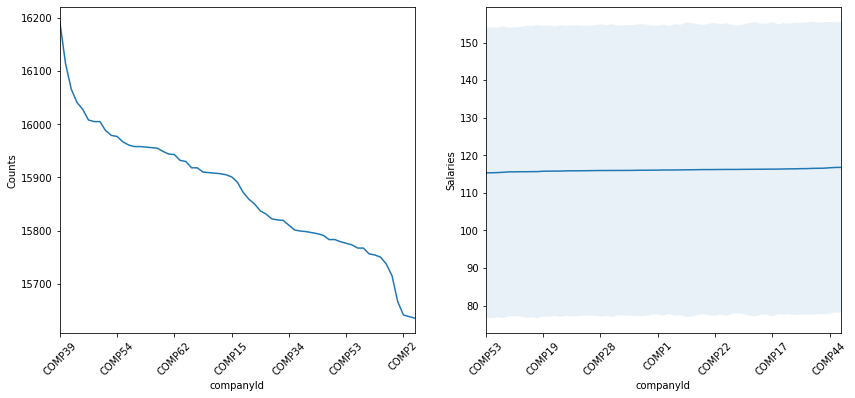

In [18]:
plot_feature(train_df,'companyId')

### Salary is weakly associated with companies. 

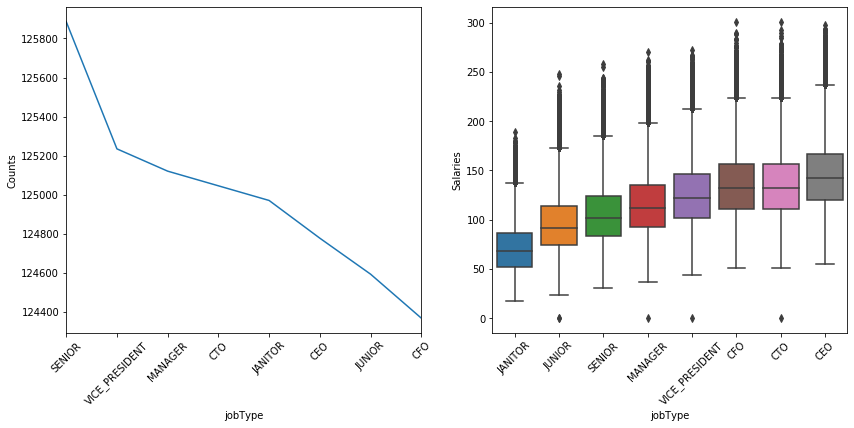

In [16]:
plot_feature(train_df,'jobType')

### There is a clear positive correlaiton between job type and salary. 

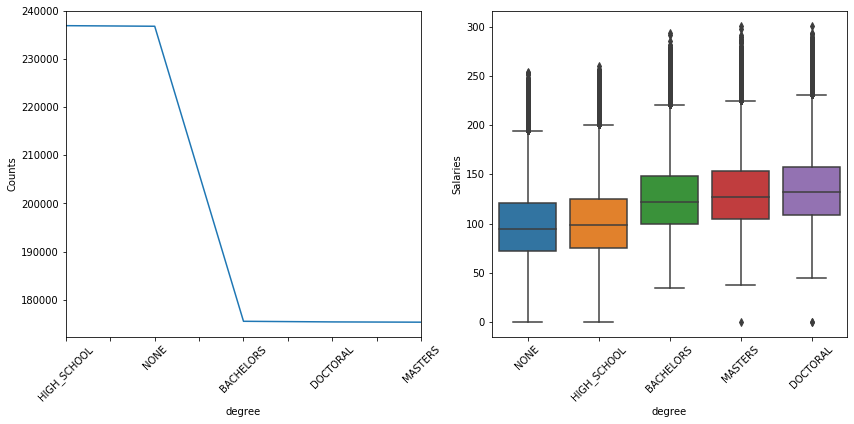

In [17]:
plot_feature(train_df,'degree')

### More advanced degrees thend to have higher salaries. 

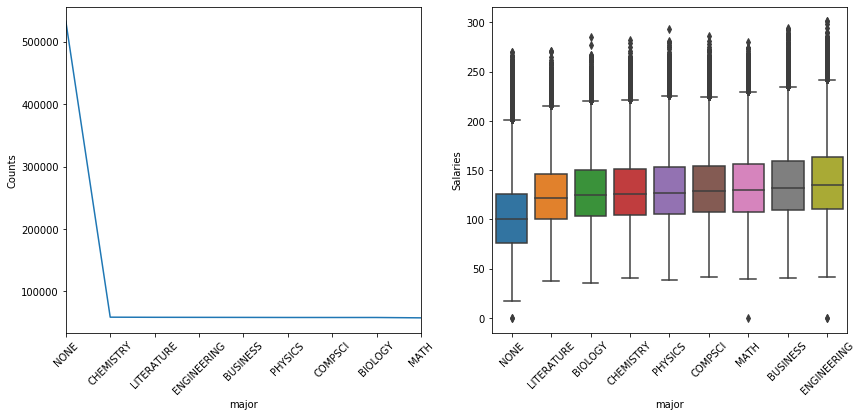

In [19]:
plot_feature(train_df,'major')

### People while majores of engineering, business, and math generally have higher salaires. 

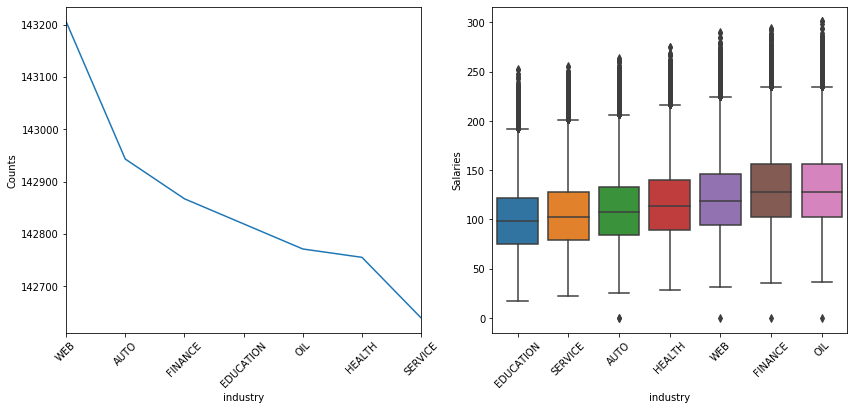

In [20]:
plot_feature(train_df,'industry')

### Regarding industries, oil, finance, and web industries generally pay better. 

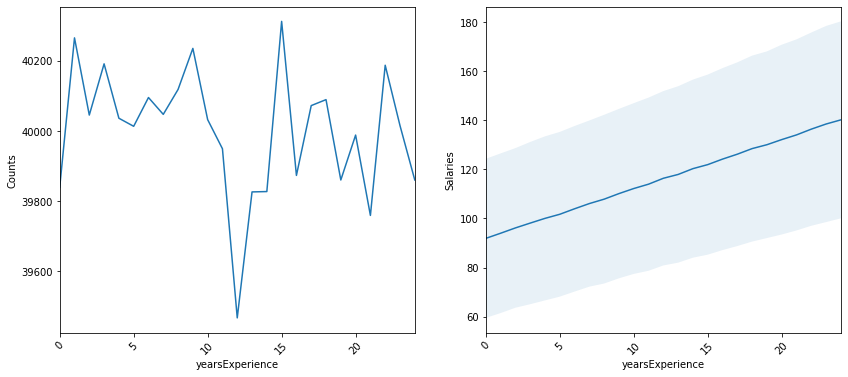

In [21]:
plot_feature(train_df,'yearsExperience')

### In general, there is a clear correlation between salary and years of experience.

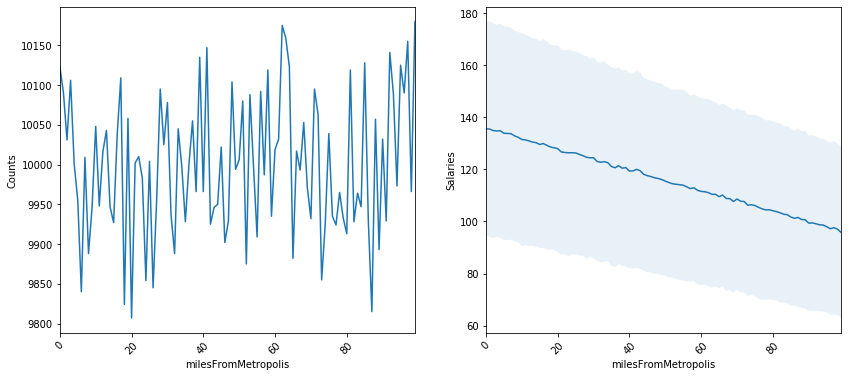

In [22]:
plot_feature(train_df,'milesFromMetropolis')

### In general, salaries decrease wtih the distance to metropolis.

In [25]:
def encode_label(df,col):
    #encode the categories using average salary for each category to replace label 
    cat_dict ={}
    cats = df[col].cat.categories.tolist()
    for cat in cats: 
        cat_dict[cat] = train_df[train_df[col] == cat]['salary'].mean()
    df[col] = df[col].map(cat_dict)

In [26]:
for col in train_df.columns:
    if train_df[col].dtype.name == "category":
        encode_label(train_df, col)

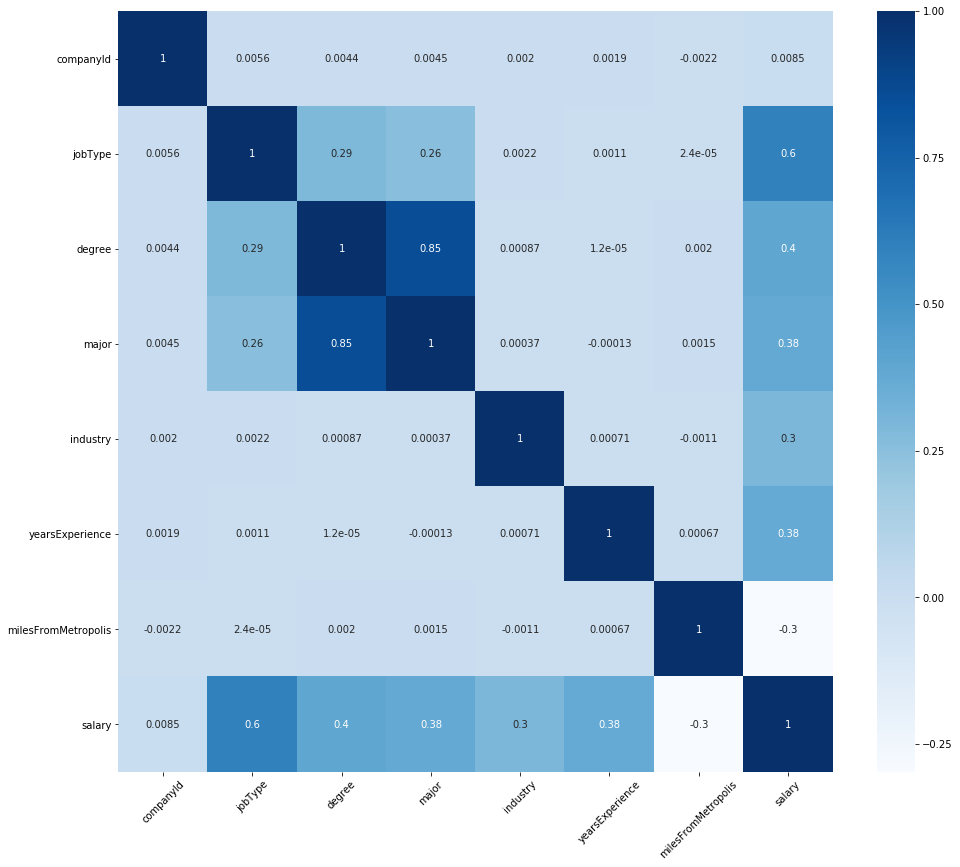

In [27]:
#Correlations between selected features and response 
#jobId is discarded because it has the weakest correlation 
fig = plt.figure(figsize = (16, 14))
features = ['companyId', 'jobType', 'degree', 'major', 'industry', 'yearsExperience', 'milesFromMetropolis']
sns.heatmap(train_df[features + ['salary']].corr(), cmap='Blues', annot=True)
plt.xticks(rotation=45)
plt.show()

#### Job type has the strongest correlation to salary followed by degree, major, and years of experience.  Also, degree and major are strongly correlated. 

### Feature Engineering

In [13]:
if __name__ == '__main__':
#define inputs
    train_feature_file = 'data/train_features.csv'
    train_target_file = 'data/train_salaries.csv'
    test_feature_file = 'data/test_features.csv'

#define variables
categorical_vars = ['companyId', 'jobType', 'degree', 'major', 'industry']
numeric_vars = ['yearsExperience', 'milesFromMetropolis']
target_var = 'salary'

#load data
print("Loading data")
feature_df = load_file('train_features.csv')
target_df = load_file('train_salaries.csv')
test_df = load_file('test_features.csv')

#consolidate training data
raw_train_df = consolidate_data(feature_df, target_df, key='jobId')

#clean, shuffle, and reindex training data -- shuffling may improve cross-validation accuracy
clean_train_df = shuffle(clean_data(raw_train_df)).reset_index()

#encode categorical data and get final feature dfs
print("Encoding data")
feature_df = one_hot_encode_feature_df(clean_train_df, cat_vars=categorical_vars, num_vars=numeric_vars)
test_df = one_hot_encode_feature_df(test_df, cat_vars=categorical_vars, num_vars=numeric_vars)

#get target df
target_df = get_target_df(clean_train_df, target_var)

Loading data
Encoding data


### Define parameters needed to create and run models. 

In [14]:
#initialize model list and dicts
models = []
mean_mse = {}
cv_std = {}
res = {}

#define number of processes to run in parallel
num_procs = 2

#shared model paramaters
verbose_lvl = 5

### Create models and begin cross validation

In [15]:
#create models -- hyperparameter tuning already done by hand for each model
lr = LinearRegression()
lr_std_pca = make_pipeline(StandardScaler(), PCA(), LinearRegression())
rf = RandomForestRegressor(n_estimators=60, n_jobs=num_procs, max_depth=25, min_samples_split=60, \
                             max_features=30, verbose=verbose_lvl)
gbm = GradientBoostingRegressor(n_estimators=40, max_depth=5, loss='ls', verbose=verbose_lvl)

models.extend([lr, lr_std_pca, rf, gbm])

#parallel cross-validate models, using MSE as evaluation metric, and print summaries
print("Beginning cross validation")
for model in models:
    train_model(model, feature_df, target_df, num_procs, mean_mse, cv_std)
    print_summary(model, mean_mse, cv_std)


Beginning cross validation

Model:
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
Average MSE:
 384.46079113702655
Standard deviation during CV:
 0.5423544218639904

Model:
 Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=None,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('linearregression',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)
Average MSE:
 384.46042643469013
Standard deviation during CV:
 0.5329766431525229

Model:
 RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=25,
                      max_features=30, max_leaf_nodes=None,
                      min_impurity_decre

### Testing the model and selecting the best algorithm

In [16]:
#choose model with lowest mse
model = min(mean_mse, key=mean_mse.get)
print('\nPredictions calculated using model with lowest MSE:')
print(model)

#train model on entire dataset
model.fit(feature_df, target_df)

#create predictions based on test data
predictions = model.predict(test_df)


Predictions calculated using model with lowest MSE:
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=25,
                      max_features=30, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=60,
                      min_weight_fraction_leaf=0.0, n_estimators=60, n_jobs=2,
                      oob_score=False, random_state=None, verbose=5,
                      warm_start=False)


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 60building tree 2 of 60

building tree 3 of 60
building tree 4 of 60
building tree 5 of 60
building tree 6 of 60
building tree 7 of 60
building tree 8 of 60
building tree 9 of 60
building tree 10 of 60
building tree 11 of 60
building tree 12 of 60
building tree 13 of 60
building tree 14 of 60
building tree 15 of 60
building tree 16 of 60


[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:   53.6s


building tree 17 of 60
building tree 18 of 60
building tree 19 of 60
building tree 20 of 60
building tree 21 of 60
building tree 22 of 60
building tree 23 of 60
building tree 24 of 60
building tree 25 of 60
building tree 26 of 60
building tree 27 of 60
building tree 28 of 60
building tree 29 of 60
building tree 30 of 60
building tree 31 of 60
building tree 32 of 60
building tree 33 of 60
building tree 34 of 60
building tree 35 of 60
building tree 36 of 60
building tree 37 of 60
building tree 38 of 60
building tree 39 of 60
building tree 40 of 60
building tree 41 of 60
building tree 42 of 60
building tree 43 of 60
building tree 44 of 60
building tree 45 of 60
building tree 46 of 60
building tree 47 of 60
building tree 48 of 60
building tree 49 of 60
building tree 50 of 60
building tree 51 of 60
building tree 52 of 60
building tree 53 of 60
building tree 54 of 60
building tree 55 of 60
building tree 56 of 60
building tree 57 of 60
building tree 58 of 60
building tree 59 of 60
building tr

[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:  3.8min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    3.3s
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:   12.9s finished


### Storing feature importances

In [17]:
#store feature importances
if hasattr(model, 'feature_importances_'):
    importances = model.feature_importances_
else:
    #linear models don't have feature_importances_
    importances = [0]*len(feature_df.columns)

feature_importances = pd.DataFrame({'feature':feature_df.columns, 'importance':importances})
feature_importances.sort_values(by='importance', ascending=False, inplace=True)
    
#set index to 'feature'
feature_importances.set_index('feature', inplace=True, drop=True)

### Plotting and saving results 

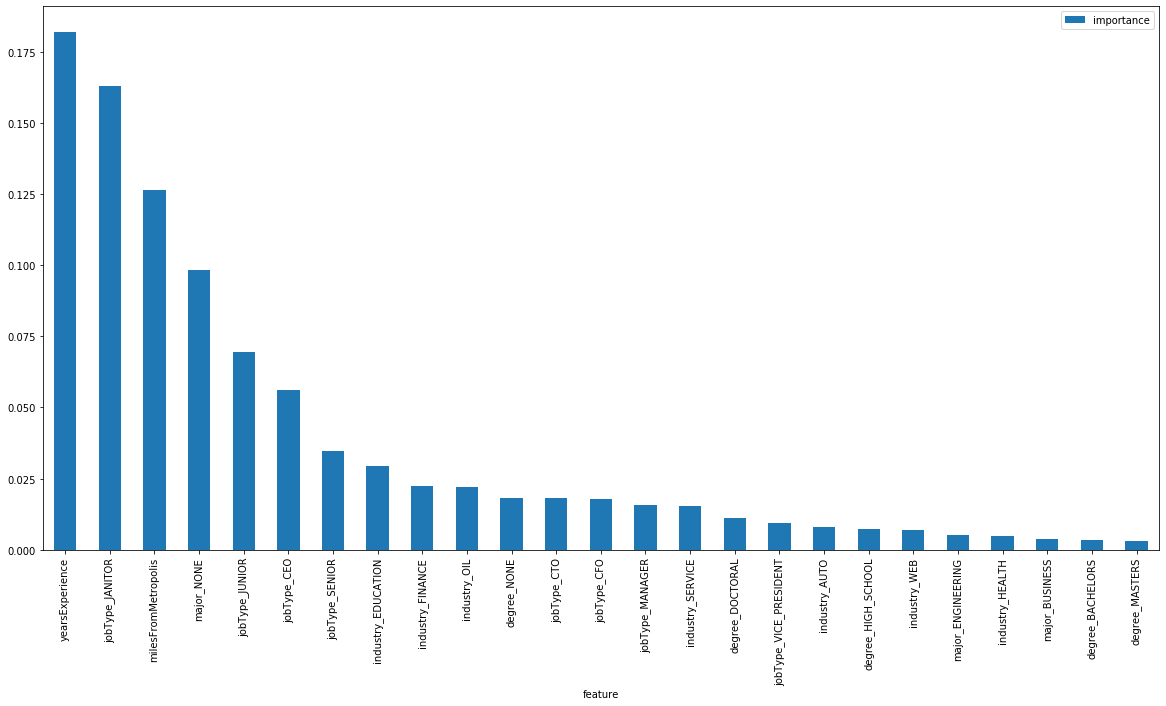

In [18]:
#create plot
feature_importances[0:25].plot.bar(figsize=(20,10))
plt.show()

#save results
save_results(model, mean_mse[model], predictions, feature_importances)

### The MSE of 368 is too high, I am still working other feature engineering methods to make this program more accurate. 